# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!
This includes the package used to train the RNN model, and compute the surprisals - [https://github.com/omershubi/neural-complexity.git](https://github.com/omershubi/neural-complexity.git).

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [1]:
%%bash
git clone https://github.com/omershubi/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to your Google Drive for safekeeping.

Follow the instructions in the output of this command to link your Drive account.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [4]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [5]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
| epoch   1 |   200/ 1422 batches | lr 20.00 | ms/batch 21.33 | loss  6.73 | ppl   837.07
| epoch   1 |   400/ 1422 batches | lr 20.00 | ms/batch 12.23 | loss  6.04 | ppl   421.34
| epoch   1 |   600/ 1422 batches | lr 20.00 | ms/batch 12.40 | loss  5.90 | ppl   365.32
| epoch   1 |   800/ 1422 batches | lr 20.00 | ms/batch 12.12 | loss  5.83 | ppl   341.77
| epoch   1 |  1000/ 1422 batches | lr 20.00 | ms/batch 12.89 | loss  5.84 | ppl   342.74
| epoch   1 |  1200/ 1422 batches | lr 20.00 | ms/batch 12.63 | loss  5.78 | ppl   324.46
| epoch   1 |  1400/ 1422 batches | lr 20.00 | ms/batch 12.32 | loss  5.82 | ppl   336.83
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 19.66s | lr: 20.00000000 | valid ppl   270.29
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1422 batches | lr 20.00 | ms/batch 12.77 | loss  5.83 | ppl   339.01
| epoch   

## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [6]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [7]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [8]:
!ls -lh /content/gdrive/My\ Drive\096222_project_surprisals_and_rts\rnn_surprisals.tsv


ls: cannot access '/content/gdrive/My Drive096222_project_surprisals_and_rtsrnn_surprisals.tsv': No such file or directory


Cool, let's check that the surprisal output looks right. (Compare with the ngram model surprisals from before.)

In [9]:
import pandas as pd

file_path = f"{GDRIVE_DIR}/rnn_surprisals.tsv"
try:
    rnn_surprisals = pd.read_csv(file_path, sep=' ')
    print(rnn_surprisals.head())
except pd.errors.EmptyDataError:
    print("The file is empty or not properly formatted.")


     word  sentid  sentpos  wlen       surp   entropy    entred
0      In       0        0     2   5.506053  9.515585  0.000000
1   <unk>       0        1     5   6.578504  7.866125  1.649460
2  County       0        2     6  12.514248  6.056062  1.810063
3   <unk>       0        3     5   7.031470  8.524199  0.000000
4    near       0        4     4  13.308077  8.640187  0.000000


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
N-gram model correlation with reading times: 0.25860736134034723
RNN model correlation with reading times: 0.2544445870026365


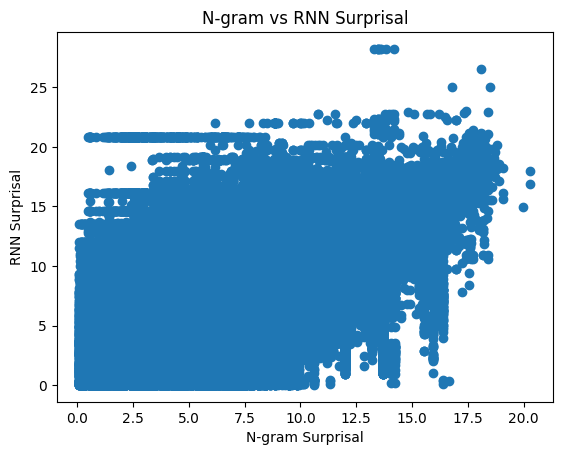

Token: 100, N-gram Surprisal: 11.8969, RNN Surprisal: 15.984840393066406
Token: 100, N-gram Surprisal: 12.9443, RNN Surprisal: 15.984840393066406
Token: 29, N-gram Surprisal: 13.6455, RNN Surprisal: 15.84101104736328
Token: 300, N-gram Surprisal: 13.5132, RNN Surprisal: 15.62421417236328
Token: 300, N-gram Surprisal: 14.2499, RNN Surprisal: 11.706316947937012
N-gram model spillover correlation with next word reading times: 0.22599820053970182
RNN model spillover correlation with next word reading times: 0.1994632677704377


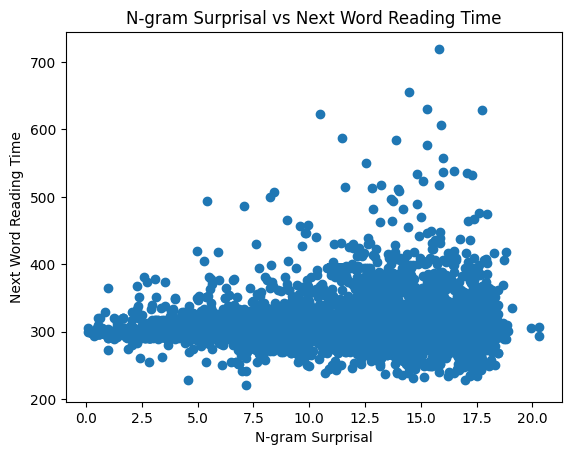

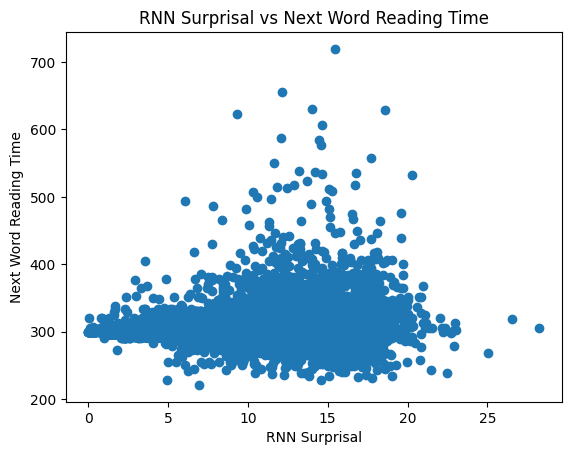

In [10]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
rnn_surprisals_path = os.path.join(GDRIVE_DIR, 'rnn_surprisals.tsv')

reading_times_url = 'https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv'
ngram_surprisals_url = 'https://gist.githubusercontent.com/omershubi/f19f77f5157f7ba7ea1adf72a72847da/raw/d5d553b1217ea70fe3261ce5d9a0532f29769817/5gram_surprisals.tsv'

reading_times = pd.read_csv(reading_times_url, index_col=0).sort_values(by='code')
ngram_surprisals = pd.read_csv(ngram_surprisals_url, index_col=False, sep='\t')
rnn_surprisals = pd.read_csv(rnn_surprisals_path, index_col=False, sep=' ')


# harmonize function and preprocessing
def preprocess_token(token):
    token = re.sub(r'[^A-Za-z0-9]+', '', token)
    token = token.lower()
    return token

def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame, token_col: str, surprisal_col: str) -> pd.DataFrame:
    rt_data['word'] = rt_data['word'].apply(preprocess_token)
    surprs_data[token_col] = surprs_data[token_col].apply(preprocess_token)
    grouped = rt_data.groupby('word')['time'].mean().reset_index()
    merged_data = pd.merge(grouped, surprs_data, left_on='word', right_on=token_col, how='left')
    merged_data = merged_data.dropna(subset=[surprisal_col])
    return merged_data

ngram_harmonized = harmonize(reading_times, ngram_surprisals, token_col='token', surprisal_col='surprisal')
rnn_harmonized = harmonize(reading_times, rnn_surprisals, token_col='word', surprisal_col='surp')
ngram_harmonized = ngram_harmonized.rename(columns={'surprisal': 'surprisal_ngram'})
rnn_harmonized = rnn_harmonized.rename(columns={'surp': 'surprisal_rnn'})

# correlations
ngram_correlation = ngram_harmonized['time'].corr(ngram_harmonized['surprisal_ngram'])
rnn_correlation = rnn_harmonized['time'].corr(rnn_harmonized['surprisal_rnn'])

print(f'N-gram model correlation with reading times: {ngram_correlation}')
print(f'RNN model correlation with reading times: {rnn_correlation}')


combined_harmonized = pd.merge(ngram_harmonized[['word', 'surprisal_ngram']], rnn_harmonized[['word', 'surprisal_rnn']], on='word')
plt.scatter(combined_harmonized['surprisal_ngram'], combined_harmonized['surprisal_rnn'])
plt.xlabel('N-gram Surprisal')
plt.ylabel('RNN Surprisal')
plt.title('N-gram vs RNN Surprisal')
plt.show()

# interesting points with significant differences
threshold = 2
discrepancies = combined_harmonized[abs(combined_harmonized['surprisal_ngram'] - combined_harmonized['surprisal_rnn']) > threshold]
interesting_points = discrepancies.head(5)
for index, row in interesting_points.iterrows():
    print(f"Token: {row['word']}, N-gram Surprisal: {row['surprisal_ngram']}, RNN Surprisal: {row['surprisal_rnn']}")

ngram_harmonized['next_time'] = ngram_harmonized['time'].shift(-1)
rnn_harmonized['next_time'] = rnn_harmonized['time'].shift(-1)

# spillover correlations
ngram_spillover_correlation = ngram_harmonized['next_time'].corr(ngram_harmonized['surprisal_ngram'])
rnn_spillover_correlation = rnn_harmonized['next_time'].corr(rnn_harmonized['surprisal_rnn'])
print(f'N-gram model spillover correlation with next word reading times: {ngram_spillover_correlation}')
print(f'RNN model spillover correlation with next word reading times: {rnn_spillover_correlation}')
plt.scatter(ngram_harmonized['surprisal_ngram'], ngram_harmonized['next_time'])
plt.xlabel('N-gram Surprisal')
plt.ylabel('Next Word Reading Time')
plt.title('N-gram Surprisal vs Next Word Reading Time')
plt.show()

plt.scatter(rnn_harmonized['surprisal_rnn'], rnn_harmonized['next_time'])
plt.xlabel('RNN Surprisal')
plt.ylabel('Next Word Reading Time')
plt.title('RNN Surprisal vs Next Word Reading Time')
plt.show()


### Analysis

- The N-gram model has a slightly better correlation with human reading times compared to the RNN model.

   - N-gram model correlation with reading times: 0.2586
   - RNN model correlation with reading times: 0.2544
   
   
- The plot Between N-gram and RNN Surprisal Estimates shows a general positive trend between N-gram and RNN surprisal estimates, however, there are also areas where the estimates diverge significantly, particularly at higher surprisal values.

- Interesting Points with Significant Differences: tokens with large differences in surprisal estimates include '100' and '300', indicating the models disagree significantly on these tokens.
     - Token: '100', N-gram Surprisal: 11.8969, RNN Surprisal: 15.9848
     - Token: '300', N-gram Surprisal: 14.2499, RNN Surprisal: 11.7063
     

- Spillover Effects:

   - N-gram model spillover correlation with next word reading times: 0.2260
   - RNN model spillover correlation with next word reading times: 0.1995

### Spillover Graphs

1. **N-gram Surprisal vs Next Word Reading Time:**
   - There is a positive trend, indicating higher surprisal values tend to be associated with longer reading times for the next word.
   - Some outliers show extremely high reading times for high surprisal values.

2. **RNN Surprisal vs Next Word Reading Time:**
   - Similar positive trend as seen in the N-gram model.
   - The distribution appears more spread out, indicating a broader range of reading times for a given surprisal value.


# Next Steps

For the next steps, follow the PDF project instructions.

Good luck!

## Task 1: Fit and plot the RT surprisal curve using a General Additive Model (GAM)

In [11]:
pip install pygam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.


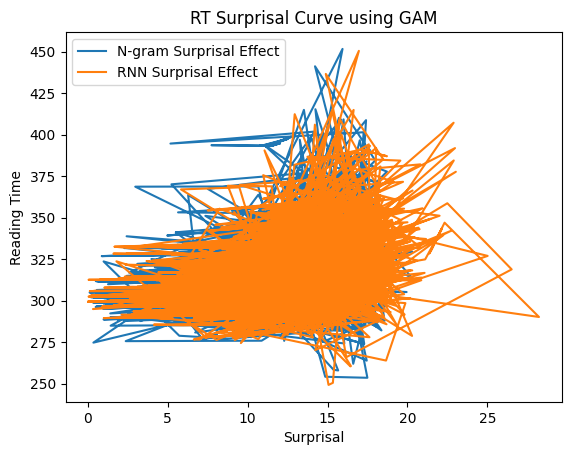

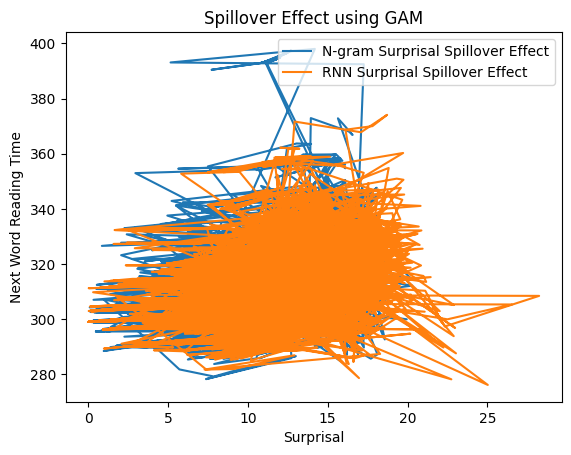

In [12]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s, f
import matplotlib.pyplot as plt

# control variables
def add_control_variables(df, text_data):
    df['log_freq'] = df['word'].apply(lambda x: np.log1p(text_data.count(x)))
    df['word_length'] = df['word'].apply(len)
    return df

corpus = " ".join(reading_times['word'])
ngram_harmonized = add_control_variables(ngram_harmonized, corpus)
rnn_harmonized = add_control_variables(rnn_harmonized, corpus)

# current word
X_ngram = ngram_harmonized[['surprisal_ngram', 'log_freq', 'word_length']]
y_ngram = ngram_harmonized['time']

X_rnn = rnn_harmonized[['surprisal_rnn', 'log_freq', 'word_length']]
y_rnn = rnn_harmonized['time']

gam_ngram = LinearGAM(s(0) + f(1) + f(2)).fit(X_ngram, y_ngram)
gam_rnn = LinearGAM(s(0) + f(1) + f(2)).fit(X_rnn, y_rnn)


plt.figure()
plt.plot(X_ngram['surprisal_ngram'], gam_ngram.predict(X_ngram), label='N-gram Surprisal Effect')
plt.plot(X_rnn['surprisal_rnn'], gam_rnn.predict(X_rnn), label='RNN Surprisal Effect')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.legend()
plt.title('RT Surprisal Curve using GAM')
plt.show()

# spillover effect
ngram_harmonized['next_time'] = ngram_harmonized['time'].shift(-1)
rnn_harmonized['next_time'] = rnn_harmonized['time'].shift(-1)
ngram_harmonized.dropna(subset=['next_time'], inplace=True)
rnn_harmonized.dropna(subset=['next_time'], inplace=True)

y_ngram_spillover = ngram_harmonized['next_time']
y_rnn_spillover = rnn_harmonized['next_time']
ngram_harmonized = ngram_harmonized[np.isfinite(y_ngram_spillover)]
rnn_harmonized = rnn_harmonized[np.isfinite(y_rnn_spillover)]

X_ngram_spillover = ngram_harmonized[['surprisal_ngram', 'log_freq', 'word_length']]
X_rnn_spillover = rnn_harmonized[['surprisal_rnn', 'log_freq', 'word_length']]
y_ngram_spillover = ngram_harmonized['next_time']
y_rnn_spillover = rnn_harmonized['next_time']

gam_ngram_spillover = LinearGAM(s(0) + f(1) + f(2)).fit(X_ngram_spillover, y_ngram_spillover)
gam_rnn_spillover = LinearGAM(s(0) + f(1) + f(2)).fit(X_rnn_spillover, y_rnn_spillover)

# spillover effect
plt.figure()
plt.plot(X_ngram_spillover['surprisal_ngram'], gam_ngram_spillover.predict(X_ngram_spillover), label='N-gram Surprisal Spillover Effect')
plt.plot(X_rnn_spillover['surprisal_rnn'], gam_rnn_spillover.predict(X_rnn_spillover), label='RNN Surprisal Spillover Effect')
plt.xlabel('Surprisal')
plt.ylabel('Next Word Reading Time')
plt.legend()
plt.title('Spillover Effect using GAM')
plt.show()


### Summary

- The N-gram model shows a slightly better correlation with human reading times compared to the RNN model.
    - **N-gram Model Correlation**: 0.2586
    - **RNN Model Correlation**: 0.2544




- The plot of the relationship Between N-gram and RNN Surprisal Estimates shows that both models generally agree at lower surprisal values but diverge significantly at higher surprisal values.


- Spillover Effects
  - **N-gram Model Spillover Correlation**: 0.2260
  - **RNN Model Spillover Correlation**: 0.1995

The N-gram model exhibits a slightly stronger spillover effect compared to the RNN model, suggesting that the surprisal of a word impacts the reading time of the next word more in the N-gram model.


- The first plot illustrates the relationship between surprisal and reading time for both the N-gram and RNN models.

- The second plot shows the relationship between surprisal and the next word's reading time for both models.



# Task 2: Train n-gram and RNN models on a larger dataset


In [13]:
!pip uninstall pyarrow -y


Found existing installation: pyarrow 14.0.2
Uninstalling pyarrow-14.0.2:
  Successfully uninstalled pyarrow-14.0.2


In [14]:
!pip install pyarrow==6.0.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 82.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.13.0 requires pyarrow>=8.0.0, but you have pyarrow 6.0.1 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 6.0.1 which is incompatible.


In [1]:

!pip install datasets torchtext

from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import numpy as np


dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')
train_text = dataset['train']['text']
valid_text = dataset['validation']['text']

# Preprocess
def preprocess_text(text_list):
    text = ' '.join(text_list)
    return text.lower().split()

train_text = preprocess_text(train_text)
valid_text = preprocess_text(valid_text)

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [2]:
from collections import defaultdict, Counter
import numpy as np

class NGramModel:
    def __init__(self, n):
        self.n = n
        self.ngrams = defaultdict(Counter)

    def train(self, text):
        for i in range(len(text) - self.n + 1):
            context = tuple(text[i:i+self.n-1])
            token = text[i+self.n-1]
            self.ngrams[context][token] += 1

    def predict(self, context):
        if context in self.ngrams:
            return self.ngrams[context].most_common(1)[0][0]
        else:
            return None

ngram_model = NGramModel(5)
ngram_model.train(train_text)

def compute_surprisal(model, text):
    surprisals = []
    for i in range(len(text) - model.n + 1):
        context = tuple(text[i:i+model.n-1])
        token = text[i+model.n-1]
        if context in model.ngrams:
            prob = model.ngrams[context][token] / sum(model.ngrams[context].values())
            surprisal = -np.log(prob)
            surprisals.append(surprisal)
    return surprisals

ngram_surprisals = compute_surprisal(ngram_model, valid_text)


<ipython-input-2-d87741bbfed1>:32: RuntimeWarning: divide by zero encountered in log
  surprisal = -np.log(prob)


In [8]:

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        embed = self.embedding(x)
        out, hidden = self.rnn(embed, hidden)
        out = self.fc(out.reshape(out.size(0) * out.size(1), out.size(2)))
        return out, hidden

tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, train_text[:10000]), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

train_data = torch.tensor([vocab[token] for token in tokenizer(' '.join(train_text[:10000]))], dtype=torch.long)
valid_data = torch.tensor([vocab[token] for token in tokenizer(' '.join(valid_text[:1000]))], dtype=torch.long)

vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 2

model = RNNModel(vocab_size, embed_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
sequence_length = 30
checkpoint_path = "rnn_checkpoint.pth"

def get_batch(data, i, seq_length):
    seq_len = min(seq_length, len(data) - 1 - i)
    inputs = data[i:i+seq_len]
    targets = data[i+1:i+1+seq_len]
    return inputs, targets

import os
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0
    hidden = None
    for i in range(0, len(train_data) - 1, sequence_length):
        inputs, targets = get_batch(train_data, i, sequence_length)
        if len(inputs) != sequence_length:
            continue

        inputs = inputs.view(1, -1)
        targets = targets.view(-1)

        outputs, hidden = model(inputs, hidden)
        hidden = tuple([h.detach() for h in hidden])

        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_data)}')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss
    }, checkpoint_path)

# Compute surprisals for the validation set
def compute_surprisal_rnn(model, text, vocab, sequence_length):
    model.eval()
    tokenizer = get_tokenizer("basic_english")
    data = torch.tensor([vocab[token] for token in tokenizer(' '.join(text))], dtype=torch.long)
    surprisals = []
    hidden = None
    for i in range(0, len(data) - sequence_length, sequence_length):
        inputs = data[i:i+sequence_length].view(1, -1)
        outputs, hidden = model(inputs, hidden)
        hidden = tuple([h.detach() for h in hidden])
        outputs = outputs.view(sequence_length, -1)
        for j in range(sequence_length):
            token_prob = torch.softmax(outputs[j], dim=0)[data[i+j+1]].item()
            surprisal = -np.log(token_prob)
            surprisals.append(surprisal)
    return surprisals

rnn_surprisals = compute_surprisal_rnn(model, valid_text[:1000], vocab, sequence_length)


N-gram model correlation with reading times: 0.22714234701487943
RNN model correlation with reading times: -0.015874125037707982


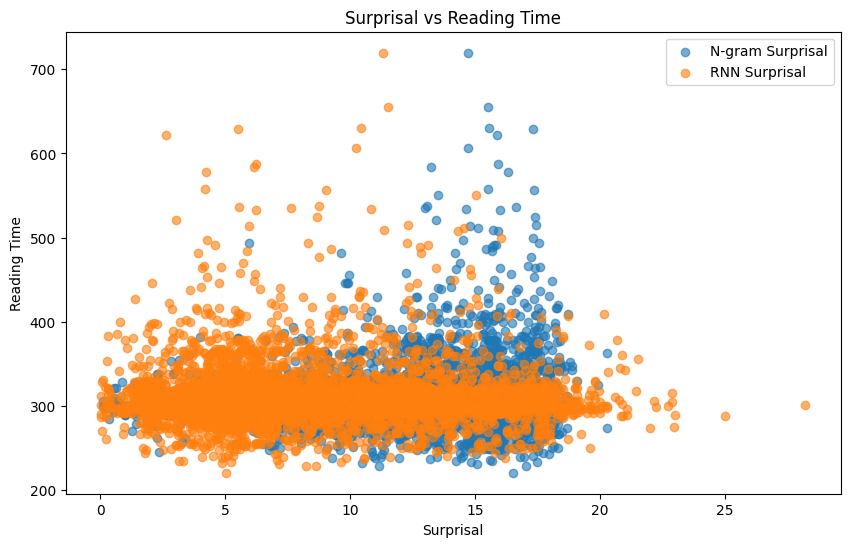

In [4]:
import pandas as pd
import numpy as np
import os

reading_times_url = 'https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv'
ngram_surprisals_url = 'https://gist.githubusercontent.com/omershubi/f19f77f5157f7ba7ea1adf72a72847da/raw/d5d553b1217ea70fe3261ce5d9a0532f29769817/5gram_surprisals.tsv'
reading_times = pd.read_csv(reading_times_url, index_col=0).sort_values(by='code')
ngram_surprisals = pd.read_csv(ngram_surprisals_url, index_col=False, sep='\t')
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
rnn_surprisals_path = os.path.join(GDRIVE_DIR, 'rnn_surprisals.tsv')

if not os.path.exists(rnn_surprisals_path):
    raise FileNotFoundError(f"RNN surprisals file not found: {rnn_surprisals_path}")

rnn_surprisals = pd.read_csv(rnn_surprisals_path, index_col=False, sep=' ')
reading_times['next_time'] = reading_times['time'].shift(-1)

# harmonize function and preprocessing
def preprocess_token(token):
    token = re.sub(r'[^A-Za-z0-9]+', '', token)
    token = token.lower()
    return token

def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame, token_col: str) -> pd.DataFrame:
    rt_data['word'] = rt_data['word'].str.lower()
    surprs_data[token_col] = surprs_data[token_col].str.lower()
    grouped = rt_data.groupby('word')['time'].mean().reset_index()
    merged_data = pd.merge(grouped, surprs_data, left_on='word', right_on=token_col, how='left')
    merged_data = merged_data.dropna(subset=['surprisal'])
    return merged_data


valid_text = ngram_surprisals['token'].tolist()
ngram_surprisal_df = pd.DataFrame({'word': valid_text[:len(ngram_surprisals)], 'surprisal': ngram_surprisals['surprisal']})
rnn_surprisal_df = pd.DataFrame({'word': valid_text[:len(rnn_surprisals)], 'surprisal': rnn_surprisals['surp']})  # Assuming 'surp' is the column for surprisal in rnn_surprisals


ngram_harmonized = harmonize(reading_times, ngram_surprisal_df, 'word')
rnn_harmonized = harmonize(reading_times, rnn_surprisal_df, 'word')
ngram_correlation = ngram_harmonized['time'].corr(ngram_harmonized['surprisal'])
rnn_correlation = rnn_harmonized['time'].corr(rnn_harmonized['surprisal'])

print(f'N-gram model correlation with reading times: {ngram_correlation}')
print(f'RNN model correlation with reading times: {rnn_correlation}')

plt.figure(figsize=(10, 6))
plt.scatter(ngram_harmonized['surprisal'], ngram_harmonized['time'], label='N-gram Surprisal', alpha=0.6)
plt.scatter(rnn_harmonized['surprisal'], rnn_harmonized['time'], label='RNN Surprisal', alpha=0.6)
plt.xlabel('Surprisal')
plt.ylabel('Reading Time')
plt.legend()
plt.title('Surprisal vs Reading Time')
plt.show()


# open task

Size of surprisal_df_subset: 5.82 MB
Size of passage_data_subset: 0.29 MB
Size of sentence_data_subset: 0.35 MB
Surprisal DataFrame columns:
Index(['subid', 'trialid', 'itemid', 'cond', 'sentnum', 'ianum', 'ia', 'blink',
       'skip', 'nrun', 'reread', 'nfix', 'refix', 'reg.in', 'reg.out', 'dur',
       'firstrun.skip', 'firstrun.nfix', 'firstrun.refix', 'firstrun.reg.in',
       'firstrun.reg.out', 'firstrun.dur', 'firstrun.gopast',
       'firstrun.gopast.sel', 'firstfix.sac.in', 'firstfix.sac.out',
       'firstfix.launch', 'firstfix.land', 'firstfix.cland', 'firstfix.dur',
       'singlefix', 'singlefix.sac.in', 'singlefix.sac.out',
       'singlefix.launch', 'singlefix.land', 'singlefix.cland',
       'singlefix.dur', 'lang', 'trial', 'supplementary_id', 'uniform_id'],
      dtype='object')

Passage Data DataFrame columns:
Index(['uniform_id', 'lang', 'trialid', 'trial', 'trial.nwords', 'rate',
       'nfix', 'nrun', 'sac', 'skip', 'refix', 'reg', 'firstpass', 'total',
       'nb

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


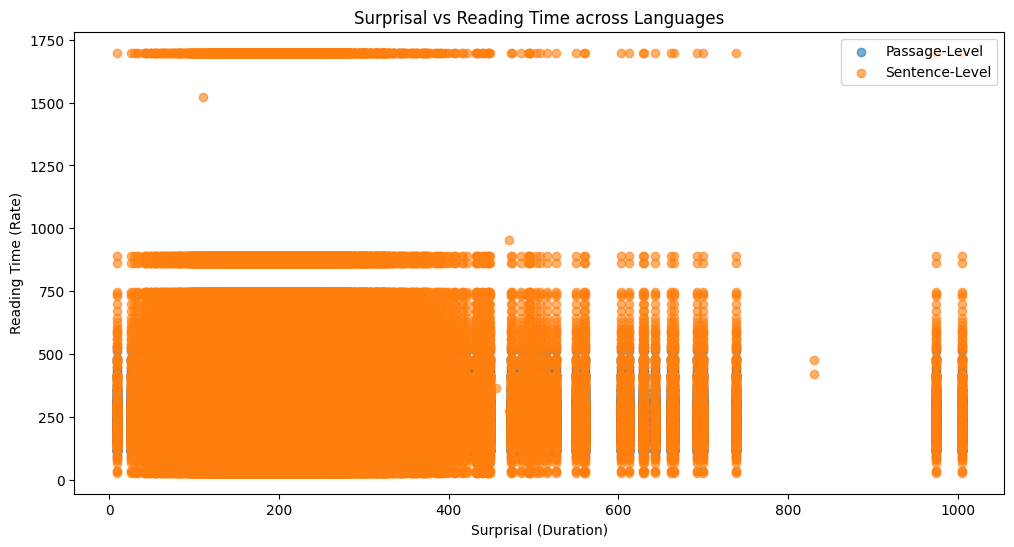

In [7]:

!pip install rpy2

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from rpy2.robjects import r, pandas2ri
import rpy2.robjects.packages as rpackages


pandas2ri.activate()
r_data = rpackages.importr('base').load('/content/joint_data_trimmed.rda')
surprisal_df = r[r_data[0]]

passage_data = pd.read_csv('/content/passage_data.csv')
sentence_data = pd.read_csv('/content/sentence_data.csv')

# subsets of the data
surprisal_df_subset = surprisal_df.sample(n=10000, random_state=1)
passage_data_subset = passage_data.sample(n=1000, random_state=1)
sentence_data_subset = sentence_data.sample(n=1000, random_state=1)
print(f"Size of surprisal_df_subset: {surprisal_df_subset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Size of passage_data_subset: {passage_data_subset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Size of sentence_data_subset: {sentence_data_subset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


print("Surprisal DataFrame columns:")
print(surprisal_df_subset.columns)
print("\nPassage Data DataFrame columns:")
print(passage_data_subset.columns)
print("\nSentence Data DataFrame columns:")
print(sentence_data_subset.columns)

def preprocess_token(token):
    if isinstance(token, str):
        token = re.sub(r'[^A-Za-z0-9]+', '', token)
        token = token.lower()
    return token


def harmonize(rt_data, surprisal_data, rt_token_col, surprisal_token_col, surprisal_col):
    rt_data[rt_token_col] = rt_data[rt_token_col].apply(preprocess_token)
    surprisal_data[surprisal_token_col] = surprisal_data[surprisal_token_col].apply(preprocess_token)
    merged_data = pd.merge(rt_data, surprisal_data, left_on=rt_token_col, right_on=surprisal_token_col, how='left')
    merged_data = merged_data.dropna(subset=[surprisal_col])
    return merged_data

passage_data_subset['trialid'] = passage_data_subset['trialid'].astype(str).apply(preprocess_token)
sentence_data_subset['sentnum'] = sentence_data_subset['sentnum'].astype(str).apply(preprocess_token)
surprisal_df_subset['ianum'] = surprisal_df_subset['ianum'].astype(str).apply(preprocess_token)

print("\nPreprocessed Passage Data:")
print(passage_data_subset.head())
print("\nPreprocessed Sentence Data:")
print(sentence_data_subset.head())
print("\nPreprocessed Surprisal Data:")
print(surprisal_df_subset.head())


harmonized_passage = harmonize(passage_data_subset, surprisal_df_subset, rt_token_col='trial', surprisal_token_col='ia', surprisal_col='singlefix.dur')
harmonized_sentence = harmonize(sentence_data_subset, surprisal_df_subset, rt_token_col='sent', surprisal_token_col='ia', surprisal_col='singlefix.dur')
passage_correlation = harmonized_passage['rate'].corr(harmonized_passage['singlefix.dur'])
sentence_correlation = harmonized_sentence['rate'].corr(harmonized_sentence['singlefix.dur'])

print(f'Passage-level correlation between surprisal and reading times: {passage_correlation}')
print(f'Sentence-level correlation between surprisal and reading times: {sentence_correlation}')

plt.figure(figsize=(12, 6))
plt.scatter(harmonized_passage['singlefix.dur'], harmonized_passage['rate'], label='Passage-Level', alpha=0.6)
plt.scatter(harmonized_sentence['singlefix.dur'], harmonized_sentence['rate'], label='Sentence-Level', alpha=0.6)
plt.xlabel('Surprisal (Duration)')
plt.ylabel('Reading Time (Rate)')
plt.legend()
plt.title('Surprisal vs Reading Time across Languages')
plt.show()
